# Synopsis

Explore data generated by MALLET.

# Configuration

Use this URL https://collab.its.virginia.edu/x/Ab990I to download the database. Move the into this notebook's directory (if you did not download the file into it) and then unzip it.

In [1]:
model_db_file = '/Users/rca2t/CODE/polo2-test/PUB/winereviews/winereviews-mallet-trial1.db'  # CHANGE THIS
thresh = .01 # The minimum topic weight 

# Libraries

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Pragmas

In [3]:
%matplotlib inline
sns.set()

# Process

## Function to import tables

In [4]:
def get_table(table, db_file, fields='*', index_col=None):
    if type(fields) is list:
        fields = ','.join(fields)
    with sqlite3.connect(db_file) as db:
        return pd.read_sql("select {} from {}".format(fields, table), db, index_col=index_col)

## Import primary model tables

Explore the database in a SQLite browser first 

In [5]:
doc = get_table('doc', model_db_file, index_col=['doc_id'])
topic = get_table('topic', model_db_file,  index_col=['topic_id'])
doctopic = get_table('doctopic', model_db_file, ['doc_id','topic_id','topic_weight'], ['doc_id','topic_id'])
topicword = get_table('topicword', model_db_file, ['topic_id','word_id','word_count'], ['topic_id','word_id'])
docword = get_table('docword', model_db_file, index_col=['doc_id','word_pos'])
vocab = get_table('word', model_db_file)

## Inspect DOCWORD and create THETA

In [6]:
docword.head()

word_id  topic_id
doc_id word_pos                   
0      0               0        15
       1               1        15
       2               2        15
       3               3        15
       4               4        15

In [7]:
docword['word_str'] = docword.word_id.map(vocab.word_str)

In [8]:
docword.head()

word_id  topic_id   word_str
doc_id word_pos                              
0      0               0        15   tropical
       1               1        15      fruit
       2               2        15      broom
       3               3        15  brimstone
       4               4        15      dried

In [9]:
THETA = doctopic.unstack()
THETA.columns = THETA.columns.droplevel(0)

In [10]:
THETA.head()

topic_id,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
doc_id,,,,,,,,,,,,,,,,,,,,,
0,0.001310,0.000990,0.001766,0.001123,0.000899,0.000643,0.000293,0.000602,0.001507,0.000971,...,0.000907,0.000827,0.000988,0.000732,0.001339,0.001076,0.001017,0.001090,0.000620,0.000710
1,0.054541,0.000990,0.001766,0.001123,0.000899,0.000643,0.000293,0.000602,0.001507,0.000971,...,0.000907,0.000827,0.000988,0.000732,0.001339,0.001076,0.001017,0.001090,0.000620,0.000710
2,0.001558,0.001179,0.002102,0.001336,0.001069,0.000765,0.000349,0.000716,0.001794,0.001156,...,0.001079,0.000984,0.001176,0.000871,0.001594,0.001281,0.888077,0.001297,0.000738,0.000845
3,0.001243,0.000940,0.001677,0.001066,0.000853,0.000610,0.000278,0.000572,0.001431,0.000922,...,0.000861,0.000785,0.000938,0.000695,0.001272,0.001022,0.152589,0.001035,0.000589,0.000674
4,0.001129,0.000854,0.093326,0.000968,0.322083,0.000554,0.000253,0.000519,0.001300,0.000837,...,0.000782,0.000713,0.000852,0.000631,0.001155,0.000928,0.000877,0.000940,0.000535,0.000612


### View topic mixture for sample doc

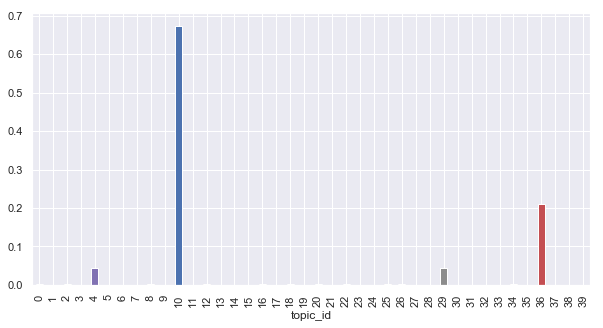

In [11]:
THETA.loc[100].plot(kind='bar', figsize=(10,5))

In [12]:
THETA.sum(1).head()

doc_id
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

## Inspect TOPICWORD and create PHI

In [13]:
PHI = topicword.unstack().fillna(0)
PHI.columns = PHI.columns.droplevel(0)
PHI = PHI / PHI.sum()
PHI.columns = vocab.word_str

### View for weights of sample word across topics

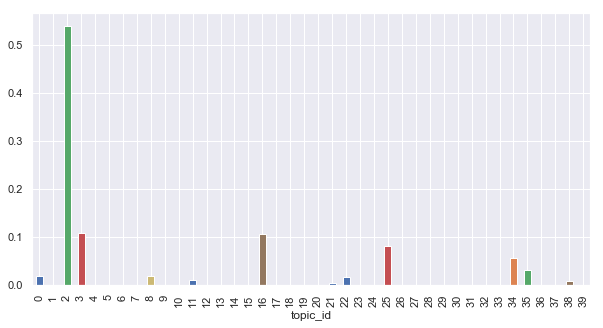

In [14]:
PHI['tannin'].plot(kind='bar', figsize=(10,5))

## Inspect DOCWORD

DOCWORD shows the actual labels assigned to tokens. 

In [15]:
docword.loc[0] # Look at doc_id = 0

,word_id,topic_id,word_str
word_pos,,,
0,0,15,tropical
1,1,15,fruit
2,2,15,broom
3,3,15,brimstone
4,4,15,dried
5,5,15,herb
6,6,15,palate
7,7,15,overly
8,8,15,expressive


In [16]:
docword.loc[3] # Look at doc_id = 3

,word_id,topic_id,word_str
word_pos,,,
0,46,26,lemon
1,47,10,pith
2,48,29,orange
3,49,36,blossom
4,50,29,start
5,51,10,aromas
6,6,10,palate
7,52,10,bit
8,53,29,opulent


### Get docs as bags of topics 

In [17]:
BOT = docword.groupby(['doc_id','topic_id']).word_id.count().to_frame().rename(columns={'word_id':'word_count'})

In [18]:
BOT.loc[0]

,word_count
topic_id,
15,18


In [19]:
BOT.loc[3]

,word_count
topic_id,
10,8
25,1
26,1
29,6
36,3


## Topic Entropy in Documents

### Compute entropy for each row

In [20]:
DOCH = (THETA * np.log2(1/THETA)).sum(1)

In [21]:
DOCH.head()

doc_id
0    0.460246
1    0.743541
2    0.856653
3    2.243309
4    2.085180
dtype: float64

### Find docs with max and min entropy

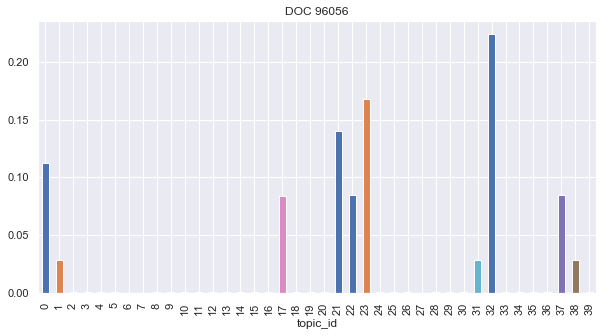

In [22]:
doc_with_most_topic_entropy = DOCH.idxmax()
THETA.loc[doc_with_most_topic_entropy].plot(kind='bar', figsize=(10,5), title='DOC {}'.format(doc_with_most_topic_entropy))

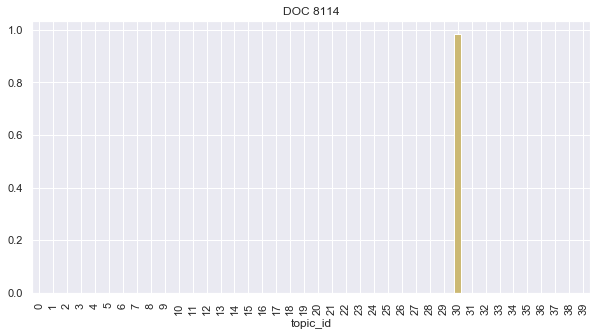

In [23]:
doc_with_least_entropy = DOCH.idxmin()
THETA.loc[doc_with_least_entropy].plot(kind='bar', figsize=(10,5), title='DOC {}'.format(doc_with_least_entropy))

### Document Topic Entropy stats

In [24]:
DOCH.describe()

count    129971.000000
mean          1.393908
std           0.579790
min           0.198894
25%           0.954354
50%           1.401327
75%           1.828418
max           3.186584
dtype: float64

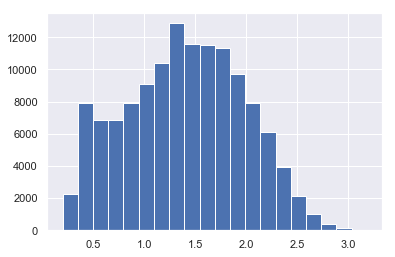

In [25]:
DOCH.hist(bins=20)

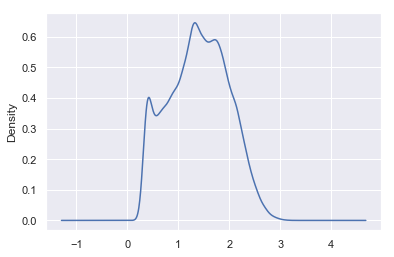

In [26]:
DOCH.plot.kde()

## Mutual Information among Topics

Treat each THETA as a shopping bag of topics

In [27]:
doc_num = doc.index.shape[0]

In [28]:
doc_num

129971

### Get topic pairs

In [29]:
topic['topic_freq'] = topic.apply(lambda x: len(THETA[THETA[x.name] >= thresh]), axis=1)
topic['topic_rel_freq'] = topic.apply(lambda x: x.topic_freq / doc_num, axis=1)

In [30]:
topic.head()

,topic_alpha,topic_words,topic_alpha_zscore,topic_gloss,topic_tokens,topic_document_entropy,topic_word_length,topic_coherence,topic_uniform_dist,topic_corpus_dist,topic_eff_num_words,topic_token_doc_diff,topic_rank_1_docs,topic_allocation_ratio,topic_allocation_count,topic_exclusivity,topic_freq,topic_rel_freq
topic_id,,,,,,,,,,,,,,,,,,
0,0.02460,years time wine fruit bottle age give cellar t...,0.746171,needs time,62267,9.1210,4.9,-96.7429,4.6692,1.8109,130.6813,0.0000,0.1432,0.0525,0.2183,0.3096,12379,0.095244
1,0.01861,flavors wine alcohol fruit high dry sweet tann...,-0.156407,high alcohol,44438,8.8563,5.8,-103.5274,4.5661,1.6297,133.4912,0.0000,0.2333,0.1346,0.2987,0.1435,9460,0.072785
2,0.03318,wine oak black cherry finish fruit palate acid...,2.039011,forest floor,117765,9.3149,5.5,-94.4197,4.0745,1.0211,231.9311,0.0001,0.3615,0.2616,0.4067,0.0780,16375,0.125990
3,0.02110,flavors wine texture aromas fruit ripe finish ...,0.218788,full bodied,73502,8.8534,5.6,-74.7433,4.8367,1.0392,102.6086,0.0001,0.3456,0.2666,0.3894,0.0672,10638,0.081849
4,0.01688,pair wine would well dishes grilled flavors ac...,-0.417084,would pair,40256,8.8245,5.3,-114.3638,4.7155,2.4236,131.3233,0.0001,0.1527,0.0550,0.2490,0.3907,8601,0.066176


In [31]:
pairs = [(x,y) for x  in topic.index  for y in topic.index if y > x]
topicpair = pd.DataFrame(pairs, columns=['topic_a_id', 'topic_b_id'])

In [32]:
topicpair.head()

,topic_a_id,topic_b_id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [33]:
def pwmi(p_a, p_b, p_ab, norm=.000001):
    """Computes the adjusted point-wise mutual information of two items (a and b)
    that appear in container vectors of some kind, e.g. items in a shopping
    basket."""
    p_ab += norm
    i_ab = np.log2(p_ab / (p_a * p_b))  # Raw
    try:
        i_ab = i_ab / (np.log2(p_ab) * -1) # Adjusted
    except ZeroDivisionError:
        i_ab = 0
    return i_ab

def get_p_ab(a, b):
    p_ab = THETA[(THETA[a] > thresh) & (THETA[b] > thresh)].index.shape[0] / doc_num
#     p_ab = len(THETA[(THETA[a] >= thresh) & (THETA[b] >= thresh)]) / doc_num
    return p_ab

def get_pwmi(a, b, p_ab):
    p_a = topic.loc[a, 'topic_rel_freq']
    p_b = topic.loc[b, 'topic_rel_freq']
    i_ab = pwmi(p_a, p_b, p_ab)
    return i_ab

In [34]:
topicpair['p_ab'] = topicpair.apply(lambda x: get_p_ab(x.topic_a_id, x.topic_b_id), axis=1)
topicpair['p_aGb'] = topicpair.apply(lambda x: x.p_ab / topic.loc[x.topic_b_id, 'topic_rel_freq'], axis=1)
topicpair['p_bGa'] = topicpair.apply(lambda x: x.p_ab / topic.loc[x.topic_a_id, 'topic_rel_freq'], axis=1)
topicpair['i_ab'] = topicpair.apply(lambda x: get_pwmi(x.topic_a_id, x.topic_b_id, x.p_ab), axis=1)

In [35]:
topicpair.head()

,topic_a_id,topic_b_id,p_ab,p_aGb,p_bGa,i_ab
0,0,1,0.006902,0.094820,0.072461,-0.000868
1,0,2,0.012495,0.099176,0.131190,0.009248
2,0,3,0.007009,0.085636,0.073592,-0.021408
3,0,4,0.005340,0.080688,0.056063,-0.031661
4,0,5,0.003124,0.065866,0.032797,-0.063882


### What topics have  highest MI?

In [36]:
exhibit_01 = topicpair.sort_values('i_ab', ascending=False).head(10)

In [37]:
exhibit_01  = exhibit_01.copy()[['topic_a_id','topic_b_id','i_ab']]

In [38]:
exhibit_01['topic_a_words'] = exhibit_01.topic_a_id.map(topic.topic_words)
exhibit_01['topic_b_words'] = exhibit_01.topic_b_id.map(topic.topic_words)

In [39]:
exhibit_01

,topic_a_id,topic_b_id,i_ab,topic_a_words,topic_b_words
406,12,17,0.151190,fruit flavors wine finish cherry mix vineyard ...,oak french new aged months wine fruit barrel f...
105,2,31,0.137697,wine oak black cherry finish fruit palate acid...,vineyard valley wine grapes vineyards cool cou...
182,4,37,0.131544,pair wine would well dishes grilled flavors ac...,wine spice aromas fruit cherry berry bright to...
688,25,39,0.124439,wine tannins fruit fruits acidity black struct...,wine tannins fruits ripe rich vines acidity vi...
473,14,33,0.117209,palate cherry tannins black aromas berry red s...,palate tannins black cherry aromas alongside o...
526,16,39,0.116135,wine acidity tannins fruits ripe red fruit sof...,wine tannins fruits ripe rich vines acidity vi...
720,28,35,0.114980,flavors fruit aromas notes spice cherry finish...,cabernet sauvignon merlot franc blend petit ve...
150,4,5,0.111466,pair wine would well dishes grilled flavors ac...,wine aromas fruit white peach citrus offers st...
306,8,31,0.091433,flavors tannins wine dry black oak blackberry ...,vineyard valley wine grapes vineyards cool cou...
545,17,36,0.085937,oak french new aged months wine fruit barrel f...,flavors blanc white apple lemon citrus sauvign...


In [40]:
exhibit_03 = topicpair.set_index(['topic_a_id','topic_b_id']).i_ab.unstack()

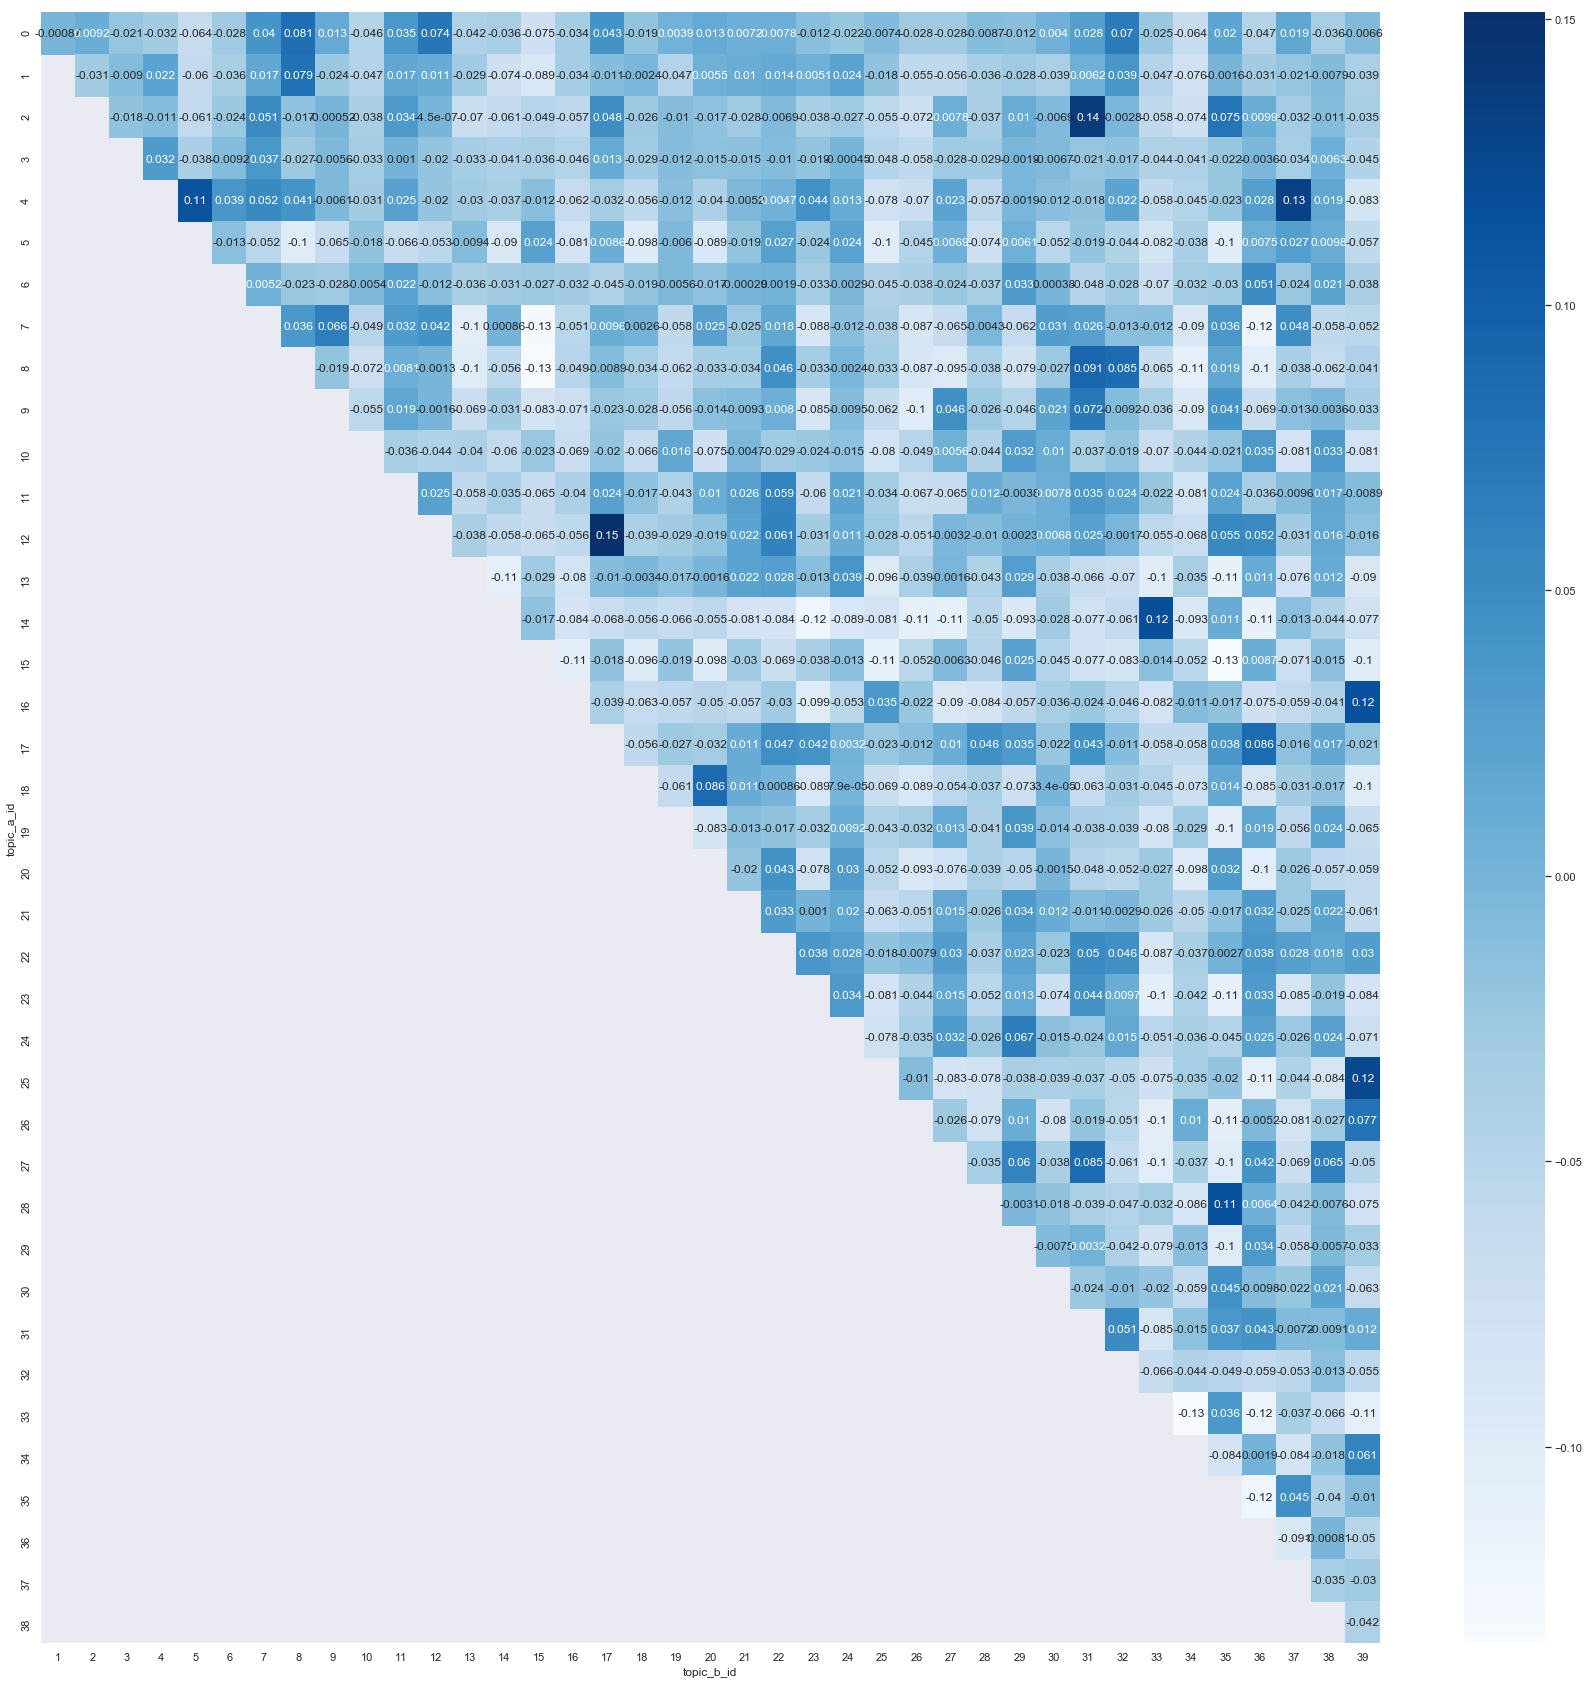

In [41]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(exhibit_03, annot=True, ax=ax, cmap='Blues')

### Compare PWMI to Corr()

In [42]:
THETACORR = THETA.corr()
THETACORR = THETACORR.unstack().to_frame().rename(columns={0:'corr'})
THETACORR = THETACORR.rename_axis(['topic_a_id','topic_b_id'])

In [43]:
THETACORR = THETACORR.reset_index()

In [44]:
exhibit_02 = THETACORR[THETACORR.topic_b_id > THETACORR.topic_a_id]\
    .sort_values('corr', ascending=False).head(10)

In [45]:
exhibit_02['topic_a_words'] = exhibit_02.topic_a_id.map(topic.topic_words)
exhibit_02['topic_b_words'] = exhibit_02.topic_b_id.map(topic.topic_words)

In [46]:
exhibit_02

,topic_a_id,topic_b_id,corr,topic_a_words,topic_b_words
111,2,31,0.080276,wine oak black cherry finish fruit palate acid...,vineyard valley wine grapes vineyards cool cou...
497,12,17,0.066828,fruit flavors wine finish cherry mix vineyard ...,oak french new aged months wine fruit barrel f...
197,4,37,0.061126,pair wine would well dishes grilled flavors ac...,wine spice aromas fruit cherry berry bright to...
1155,28,35,0.059118,flavors fruit aromas notes spice cherry finish...,cabernet sauvignon merlot franc blend petit ve...
115,2,35,0.044058,wine oak black cherry finish fruit palate acid...,cabernet sauvignon merlot franc blend petit ve...
1039,25,39,0.042551,wine tannins fruit fruits acidity black struct...,wine tannins fruits ripe rich vines acidity vi...
679,16,39,0.035007,wine acidity tannins fruits ripe red fruit sof...,wine tannins fruits ripe rich vines acidity vi...
8,0,8,0.035002,years time wine fruit bottle age give cellar t...,flavors tannins wine dry black oak blackberry ...
165,4,5,0.034063,pair wine would well dishes grilled flavors ac...,wine aromas fruit white peach citrus offers st...
32,0,32,0.028803,years time wine fruit bottle age give cellar t...,pinot flavors noir cherry raspberry cola acidi...


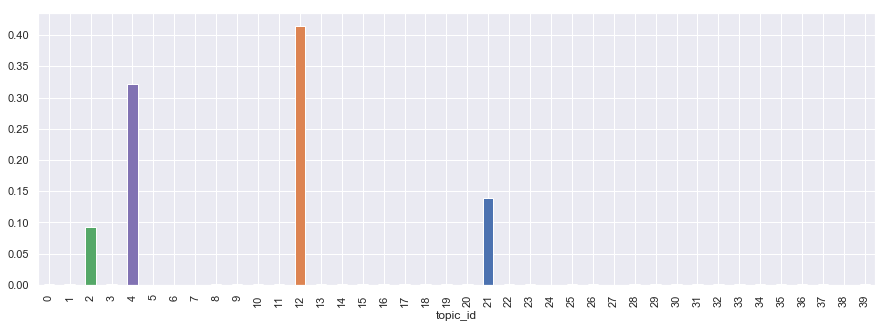

In [47]:
THETA.loc[4].plot(kind='bar', figsize=(15,5))

## Average Topics Weights by Label

In [48]:
THETA['label'] = doc.doc_label

In [49]:
THETA = THETA.reset_index().set_index(['doc_id','label'])

In [50]:
THETALABEL = THETA.groupby('label').apply(lambda x: x.mean())

### View sample label

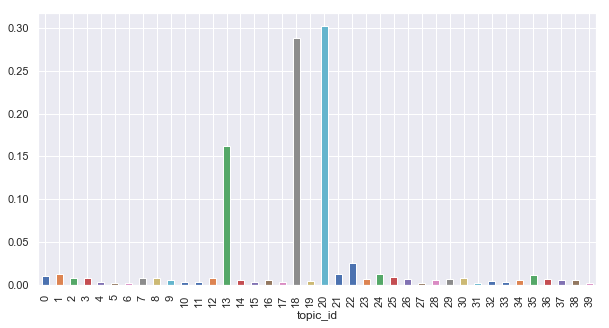

In [51]:
THETALABEL.loc['Argentina'].plot.bar(figsize=(10,5))

### Show heatmap of topics and labels

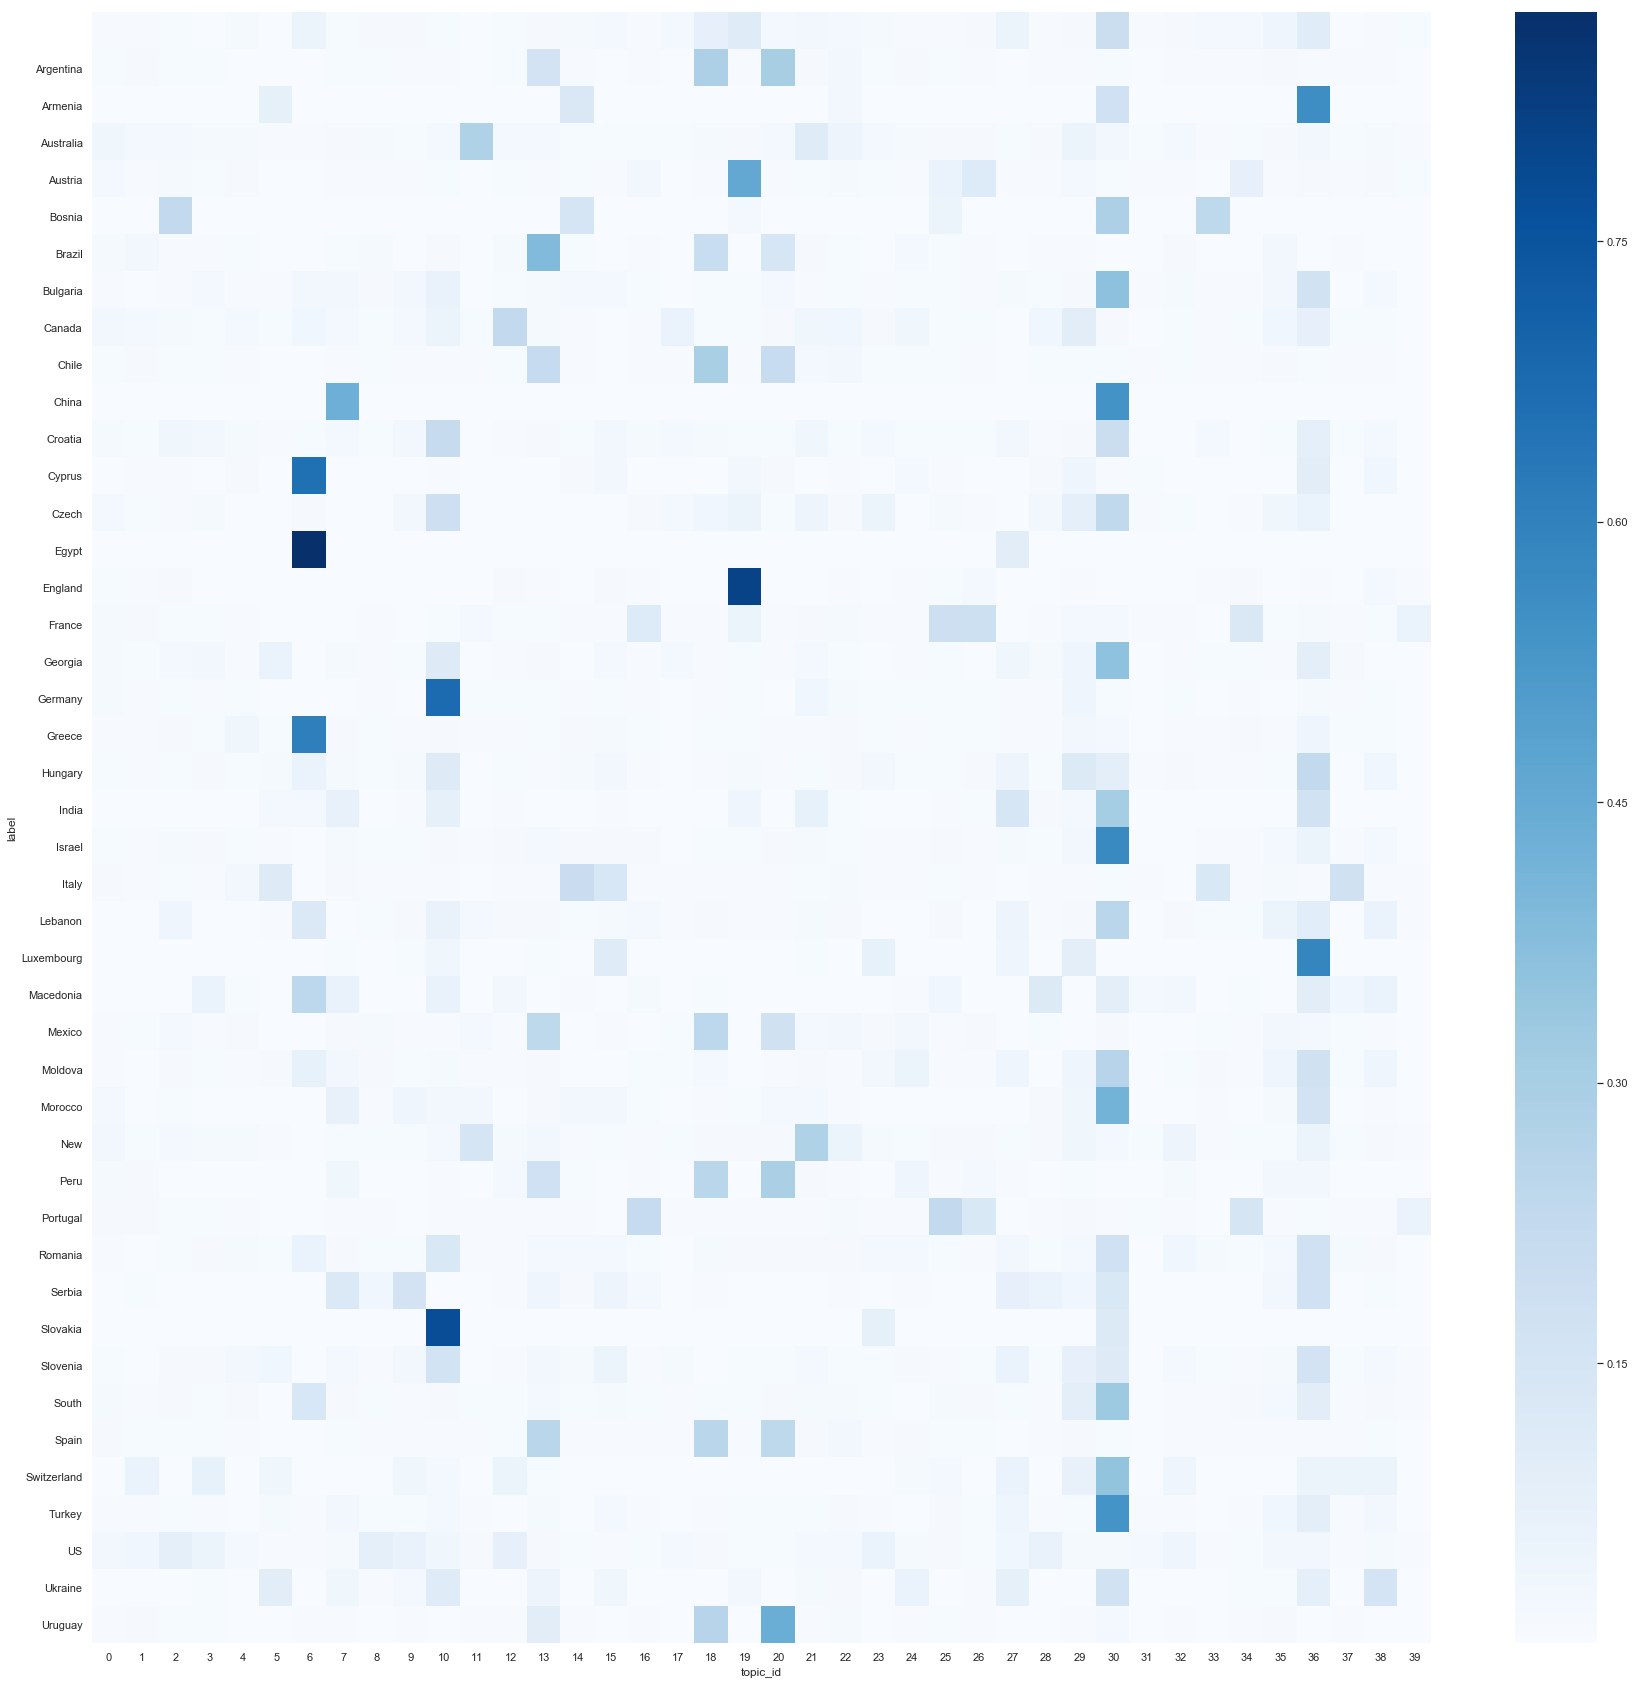

In [52]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(THETALABEL, annot=False, ax=ax, cmap='Blues')

## Topic Pair Network

### Filter pairs by threshhold

In [53]:
netpairs = topicpair.loc[topicpair.i_ab >= thresh, ['topic_a_id', 'topic_b_id', 'i_ab']].set_index(['topic_a_id','topic_b_id'])

In [54]:
netpairs.head()

i_ab
topic_a_id topic_b_id          
0          7           0.040204
           8           0.081221
           9           0.013116
           11          0.035337
           12          0.074157

### Use NetworkX library

### Use netpair index as edge list

In [55]:
edge_labels = topic.topic_gloss

In [56]:
edges = [(edge_labels.loc[i[0]], edge_labels.loc[i[1]]) for i in netpairs.index]

### Create and draw graph

In [57]:
G = nx.Graph(edges)

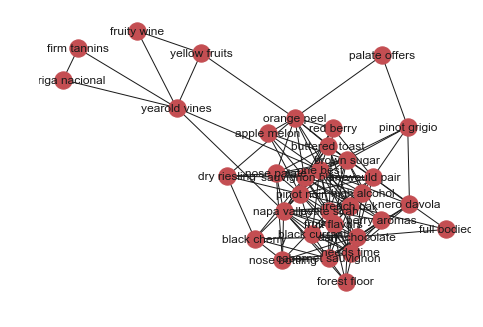

In [58]:
nx.draw(G, with_labels=True)

END